In [1]:
# If running Python 2.x, makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

from IPython.display import display, Latex, clear_output

In [2]:
import pynrc
from pynrc import nrc_utils          # Variety of useful functions and classes
from pynrc.obs_nircam import obs_hci # High-contrast imaging observation class

# Disable informational messages and only include warnings and higher
pynrc.setup_logging(level='WARN')

pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


In [3]:
from astropy.io import fits
from pynrc.nrc_utils import S

In [4]:

def miri_bp(filt):
    data_path = webbpsf.utils.get_webbpsf_data_path() + '/'
    path = data_path + 'MIRI/filters/'
    file = '{}_throughput.fits'.format(filt)
    
    hdul = fits.open(path + file)
    data = hdul[1].data
    w = data['WAVELENGTH']
    t = data['THROUGHPUT']
    
    bp = S.ArrayBandpass(w, t, name=filt)

    # Select which wavelengths to keep
    igood = nrc_utils.bp_igood(bp, min_trans=0.01, fext=0.1)
    wgood = (bp.wave)[igood]
    w1 = wgood.min()
    w2 = wgood.max()
    wrange = w2 - w1

    # Resample to common dw to ensure consistency
    dw_arr = bp.wave[1:] - bp.wave[:-1]
    #if not np.isclose(dw_arr.min(),dw_arr.max()):
    dw = np.median(dw_arr)
    warr = np.arange(w1,w2, dw)
    bp = bp.resample(warr)

    # Need to place zeros at either end so Pysynphot doesn't extrapolate
    warr = np.concatenate(([bp.wave.min()-dw],bp.wave,[bp.wave.max()+dw]))
    tarr = np.concatenate(([0],bp.throughput,[0]))
    bp   = S.ArrayBandpass(warr, tarr, name=filt)
    
    hdul.close()
    
    return bp

In [29]:
import os
from pynrc import speckle_noise as sn
def miri_opd(wfe_drift=0, drift_file=None):
    data_path = webbpsf.utils.get_webbpsf_data_path() + '/'
        
    opd = ('OPD_RevW_ote_for_MIRI_predicted.fits.gz', 0)
    opd_path = data_path + 'MIRI/OPD/'
    opd_im, header = sn.read_opd_slice(opd, opd_path=opd_path, header=True)

    opd_name = opd[0] # OPD file name
    opd_num  = opd[1] # OPD slice
    rev = [s for s in opd_name.split('_') if "Rev" in s]
    rev = '' if len(rev)==0 else rev[0]

    
    # Read in delta OPD file
    opd_dir = os.path.join(pynrc.conf.PYNRC_PATH, 'opd_mod/')
    if drift_file is None:
        drift_file = 'wfedrift_case1_var2.fits'
    delta_hdul = fits.open(opd_dir + drift_file)
        
    delta_rms = delta_hdul[0].header['RMS_WFE']
    scale_val = wfe_drift / delta_rms

    delta_data = delta_hdul[0].data * scale_val
    delta_hdul.close()

    opd_im += delta_data
    hdu = fits.PrimaryHDU(opd_im)
    hdu.header = header

    hdu.header.add_history("Modified OPD by adding delta")
    hdu.header.add_history(" from " + drift_file)
    hdu.header.add_history(" scaled by {}".format(scale_val)) 

    hdu.header['ORIGINAL'] = (opd_name, "Original OPD source")
    hdu.header['SLICE']    = (opd_num, "Slice index of original OPD")
    hdu.header['DFILE']    = (drift_file, "Source file for OPD drift")
    hdu.header['OCASE']    = (delta_hdul[0].header['CASE'], "Oscillation model case")
    hdu.header['OVARIANT'] = (delta_hdul[0].header['VARIANT'],
                                         "Oscillation model variant")
    hdu.header['OAMP']     = (scale_val, "Amplitude scale factor")
    hdu.header['WFEDRIFT'] = (wfe_drift, "WFE drift amount [nm]")

    opd_hdulist = fits.HDUList([hdu]) 

    return opd_hdulist

In [6]:
from pynrc.nrc_utils import pad_or_cut_to_size, jl_poly_fit, _wrap_coeff_for_mp
import multiprocessing as mp

def miri_coeff(inst, fov_pix, oversample, ndeg=7, nproc=1):
    
    bp = miri_bp(inst.filter)
    
    # Wavelengths to calculate monochromatic PSFs
    w1 = bp.wave.min() / 1e4
    w2 = bp.wave.max() / 1e4

    dn = 20 # N PSF simulations per um
    npsf = np.ceil(dn * (w2-w1))
    npsf = int(npsf)
    waves = np.linspace(w1, w2, npsf)

    fov_pix = 256
    oversample = 2

    worker_arguments = [(inst, wlen, fov_pix, oversample) for wlen in waves]
    if nproc > 1: 
        pool = mp.Pool(nproc)

        try:
            images = pool.map(_wrap_coeff_for_mp, worker_arguments)
            if images[0] is None:
                raise RuntimeError('Returned None values. Issue with multiprocess or WebbPSF??')
               
        except Exception as e:
            print('Caught an exception during multiprocess.')
            print('Closing multiprocess pool.')
            pool.terminate()
            pool.close()
            raise e
            
        else:
            print('Closing multiprocess pool.')
            pool.close()
    else:
        # Pass arguments to the helper function
        images = []
        for wa in worker_arguments:
            images.append(_wrap_coeff_for_mp(wa))

    images = np.array(images)
    
    # Create a set of coefficients 
    coeff_all = jl_poly_fit(waves, images, ndeg)
    
    return coeff_all

In [7]:
filt_list = ['F1065C', 'F1550C']

In [8]:
bp_k = pynrc.bp_2mass('k')

# Science         source,  dist, age, sptype, Teff, [Fe/H], log_g, mag, band
args_sources = [('alpCenA', 1.3, 4400,  'G2V', 5790, 0.20, 4.30, -1.49, bp_k)]

# References     source,  sptype, Teff, [Fe/H], log_g, mag, band
ref_sources = [('BL Cru', 'M5III', None, None, None, -0.137, bp_k),
               ('BO Mus', 'M6II', None, None, None, -0.984, bp_k),
               ('DL Cha', 'M6III', None, None, None, 1.19, bp_k),
               ('V Nor', 'M6III', None, None, None, 0.28, bp_k),
               ('eta Ara', 'K5III', 4147, -0.47, 1.06, 0.06, bp_k),
               ('eps Mus', 'M4III', None, None, None, -1.42, bp_k),
               ('del01 Aps', 'M4III', None, None, None, -0.74, bp_k),
               ('zet Ara', 'K3III', 4246, -0.40, 1.2, -0.63, bp_k)]

In [9]:
# Alpha Cen A spectrum
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci = args_sources[0]
kwargs = {'Teff':Teff_sci, 'metallicity':feh_sci, 'log_g':logg_sci}
sp_sci = pynrc.stellar_spectrum(spt_sci, mag_sci, 'vegamag', bp_sci, **kwargs)
sp_sci.name = name_sci

# F1065C

In [10]:
import webbpsf, poppy
poppy.conf.use_multiprocessing = True

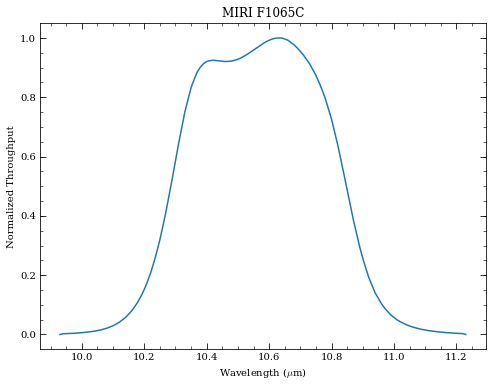

In [11]:
filt = filt_list[0]
bp = miri_bp(filt)

plt.plot(bp.wave/1e4, bp.throughput)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Normalized Throughput')

plt.title('MIRI {}'.format(filt));

In [12]:
# Basic MIRI instrument setup
inst = webbpsf.MIRI()

inst.filter = filt
inst.image_mask = 'FQPM{}'.format(filt[1:-1])
inst.pupil_mask = 'MASKFQPM'

inst.include_si_wfe = False
inst.options['source_offset_r']     = 0
inst.options['source_offset_theta'] = 0
inst.options['output_mode'] = 'oversampled'

In [13]:
fov_pix = 256
oversample = 2

In [33]:
# MIRI OPD with no WFE drift
opd_hdulist = miri_opd(wfe_drift=0)
inst.pupilopd = opd_hdulist

%time coeff0 = miri_coeff(inst, fov_pix, oversample, nproc=2)

Closing multiprocess pool.
CPU times: user 475 ms, sys: 259 ms, total: 734 ms
Wall time: 1min 20s


In [52]:
# MIRI OPD with 1 nm WFE drift
opd_hdulist = miri_opd(wfe_drift=1)
inst.pupilopd = opd_hdulist

%time coeff1 = miri_coeff(inst, fov_pix, oversample, nproc=2)

Closing multiprocess pool.
CPU times: user 534 ms, sys: 257 ms, total: 791 ms
Wall time: 1min 21s


In [34]:
# MIRI OPD with 5 nm WFE drift
opd_hdulist = miri_opd(wfe_drift=5)
inst.pupilopd = opd_hdulist

%time coeff5 = miri_coeff(inst, fov_pix, oversample, nproc=2)

Closing multiprocess pool.
CPU times: user 492 ms, sys: 310 ms, total: 802 ms
Wall time: 1min 20s


In [35]:
# MIRI OPD with 10 nm WFE drift
opd_hdulist = miri_opd(wfe_drift=10)
inst.pupilopd = opd_hdulist

%time coeff10 = miri_coeff(inst, fov_pix, oversample, nproc=2)

Closing multiprocess pool.
CPU times: user 463 ms, sys: 227 ms, total: 690 ms
Wall time: 1min 16s


In [36]:
# Science PSF
psf_sci = nrc_utils.gen_image_coeff(bp, coeff=coeff0, fov_pix=fov_pix, oversample=oversample, sp_norm=sp_sci)
sci_sub = pad_or_cut_to_size(psf_sci, (50,50))

In [37]:
obs = S.Observation(sp_sci, bp, binset=bp.wave)
star_flux = obs.countrate()

In [53]:
from pynrc.nrc_utils import dist_image, hist_indices, binned_statistic
from astropy.convolution import convolve, Gaussian1DKernel
from pynrc import robust

nsig = 5

# Radial noise
pixscale = inst.pixelscale
rho = dist_image(psf_sci, pixscale=pixscale)


cont0_dict = {}
cont1_dict = {}
cont5_dict = {}
cont10_dict = {}
for ref in ref_sources:
    name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = ref
    kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
    sp_ref = pynrc.stellar_spectrum(spt_ref, mag_ref, 'vegamag', bp_ref, **kwargs)
    sp_ref.name = name_ref
    
    print(name_ref)
    
    coeff_arr = [coeff0, coeff1, coeff5, coeff10]
    cont_arr = [cont0_dict, cont1_dict, cont5_dict, cont10_dict]
    for i, cont_dict in enumerate(cont_arr):
        kwargs = {'coeff':coeff_arr[i], 'fov_pix':fov_pix, 'oversample':oversample}
        psf_ref = nrc_utils.gen_image_coeff(bp, sp_norm=sp_ref, **kwargs)

        ref_sub = pad_or_cut_to_size(psf_ref, (50,50))
        scale = nrc_utils.scale_ref_image(sci_sub, ref_sub)
        data = psf_sci - scale * psf_ref

        # Get radial profiles
        binsize = pixscale
        bins = np.arange(rho.min(), rho.max() + binsize, binsize)
        igroups, _, rr = hist_indices(rho, bins, True)
        stds = binned_statistic(igroups, data, func=robust.medabsdev)
        stds = convolve(stds, Gaussian1DKernel(1))

        # Ignore corner regions
        arr_size = np.min(data.shape) * pixscale
        mask = rr < (arr_size/2)
        rr = rr[mask]
        stds = stds[mask]


        contrast = nsig * stds / star_flux

        cont_dict[name_ref] = (rr, contrast)

BL Cru
BO Mus
DL Cha
V Nor
eta Ara
eps Mus
del01 Aps
zet Ara


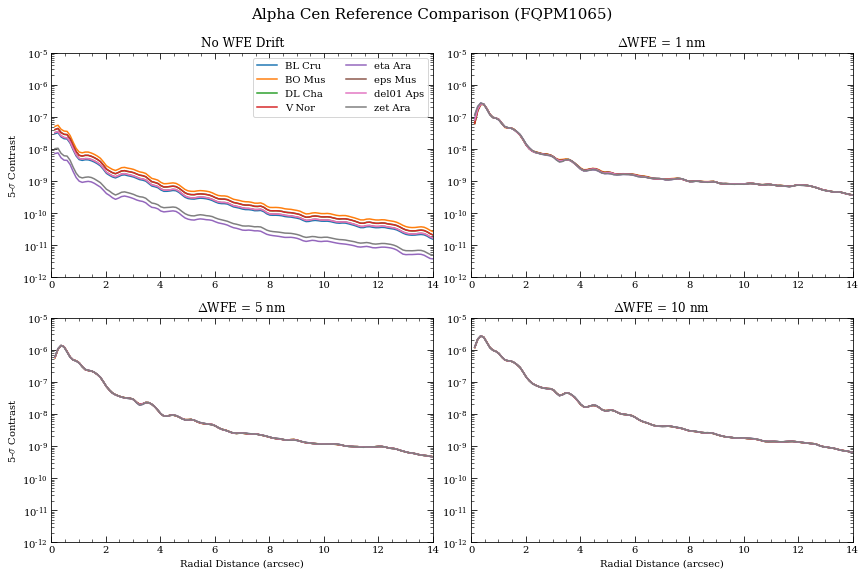

In [73]:
fig, axes = plt.subplots(2,2, figsize=(12,8))
axes = axes.flatten()
keys = list(cont_dict.keys())

for k in keys:
    rr, contrast = cont0_dict[k]
    axes[0].semilogy(rr, contrast, label=k)
    rr, contrast = cont1_dict[k]
    axes[1].semilogy(rr, contrast, label=k)
    rr, contrast = cont5_dict[k]
    axes[2].semilogy(rr, contrast, label=k)
    rr, contrast = cont10_dict[k]
    axes[3].semilogy(rr, contrast, label=k)
    
axes[0].legend(ncol=2)
fig.tight_layout()

axes[0].set_title('No WFE Drift')
axes[1].set_title('$\Delta$WFE = 1 nm')
axes[2].set_title('$\Delta$WFE = 5 nm')
axes[3].set_title('$\Delta$WFE = 10 nm')

for ax in axes:
    ax.set_ylim([1e-12,1e-5])
    ax.set_xlim([0,14])

for ax in [axes[0], axes[2]]:
    ax.set_ylabel('{}-$\sigma$ Contrast'.format(nsig))

for ax in [axes[2], axes[3]]:
    ax.set_xlabel('Radial Distance (arcsec)')
    
imask = inst.image_mask
fig.suptitle('Alpha Cen Reference Comparison ({})'.format(imask), fontsize=15)
fig.subplots_adjust(wspace=0.1, hspace=0.18, top=0.9, bottom=0.05, left=0.06)

fig.savefig('alph_cen_ref_{}.pdf'.format(imask))

# F1550C

In [75]:
import webbpsf, poppy
poppy.conf.use_multiprocessing = True

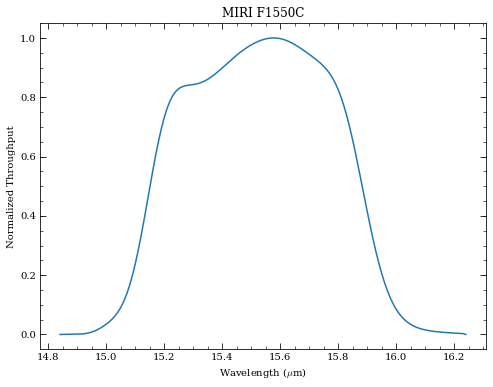

In [76]:
filt = filt_list[1]
bp = miri_bp(filt)

plt.plot(bp.wave/1e4, bp.throughput)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Normalized Throughput')

plt.title('MIRI {}'.format(filt));

In [77]:
# Basic MIRI instrument setup
inst = webbpsf.MIRI()

inst.filter = filt
inst.image_mask = 'FQPM{}'.format(filt[1:-1])
inst.pupil_mask = 'MASKFQPM'

inst.include_si_wfe = False
inst.options['source_offset_r']     = 0
inst.options['source_offset_theta'] = 0
inst.options['output_mode'] = 'oversampled'

In [78]:
fov_pix = 256
oversample = 2

In [79]:
# MIRI OPD with no WFE drift
opd_hdulist = miri_opd(wfe_drift=0)
inst.pupilopd = opd_hdulist

%time coeff0 = miri_coeff(inst, fov_pix, oversample, nproc=2)

Closing multiprocess pool.
CPU times: user 461 ms, sys: 227 ms, total: 689 ms
Wall time: 1min 25s


In [80]:
# MIRI OPD with 1 nm WFE drift
opd_hdulist = miri_opd(wfe_drift=1)
inst.pupilopd = opd_hdulist

%time coeff1 = miri_coeff(inst, fov_pix, oversample, nproc=2)

Closing multiprocess pool.
CPU times: user 474 ms, sys: 237 ms, total: 711 ms
Wall time: 1min 23s


In [81]:
# MIRI OPD with 5 nm WFE drift
opd_hdulist = miri_opd(wfe_drift=5)
inst.pupilopd = opd_hdulist

%time coeff5 = miri_coeff(inst, fov_pix, oversample, nproc=2)

Closing multiprocess pool.
CPU times: user 497 ms, sys: 291 ms, total: 787 ms
Wall time: 1min 27s


In [82]:
# MIRI OPD with 10 nm WFE drift
opd_hdulist = miri_opd(wfe_drift=10)
inst.pupilopd = opd_hdulist

%time coeff10 = miri_coeff(inst, fov_pix, oversample, nproc=2)

Closing multiprocess pool.
CPU times: user 462 ms, sys: 281 ms, total: 742 ms
Wall time: 1min 25s


In [83]:
# Science PSF
psf_sci = nrc_utils.gen_image_coeff(bp, coeff=coeff0, fov_pix=fov_pix, oversample=oversample, sp_norm=sp_sci)
sci_sub = pad_or_cut_to_size(psf_sci, (50,50))

In [84]:
obs = S.Observation(sp_sci, bp, binset=bp.wave)
star_flux = obs.countrate()

In [85]:
from pynrc.nrc_utils import dist_image, hist_indices, binned_statistic
from astropy.convolution import convolve, Gaussian1DKernel
from pynrc import robust

nsig = 5

# Radial noise
pixscale = inst.pixelscale
rho = dist_image(psf_sci, pixscale=pixscale)


cont0_dict = {}
cont1_dict = {}
cont5_dict = {}
cont10_dict = {}
for ref in ref_sources:
    name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = ref
    kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
    sp_ref = pynrc.stellar_spectrum(spt_ref, mag_ref, 'vegamag', bp_ref, **kwargs)
    sp_ref.name = name_ref
    
    print(name_ref)
    
    coeff_arr = [coeff0, coeff1, coeff5, coeff10]
    cont_arr = [cont0_dict, cont1_dict, cont5_dict, cont10_dict]
    for i, cont_dict in enumerate(cont_arr):
        kwargs = {'coeff':coeff_arr[i], 'fov_pix':fov_pix, 'oversample':oversample}
        psf_ref = nrc_utils.gen_image_coeff(bp, sp_norm=sp_ref, **kwargs)

        ref_sub = pad_or_cut_to_size(psf_ref, (50,50))
        scale = nrc_utils.scale_ref_image(sci_sub, ref_sub)
        data = psf_sci - scale * psf_ref

        # Get radial profiles
        binsize = pixscale
        bins = np.arange(rho.min(), rho.max() + binsize, binsize)
        igroups, _, rr = hist_indices(rho, bins, True)
        stds = binned_statistic(igroups, data, func=robust.medabsdev)
        stds = convolve(stds, Gaussian1DKernel(1))

        # Ignore corner regions
        arr_size = np.min(data.shape) * pixscale
        mask = rr < (arr_size/2)
        rr = rr[mask]
        stds = stds[mask]


        contrast = nsig * stds / star_flux

        cont_dict[name_ref] = (rr, contrast)

BL Cru
BO Mus
DL Cha
V Nor
eta Ara
eps Mus
del01 Aps
zet Ara


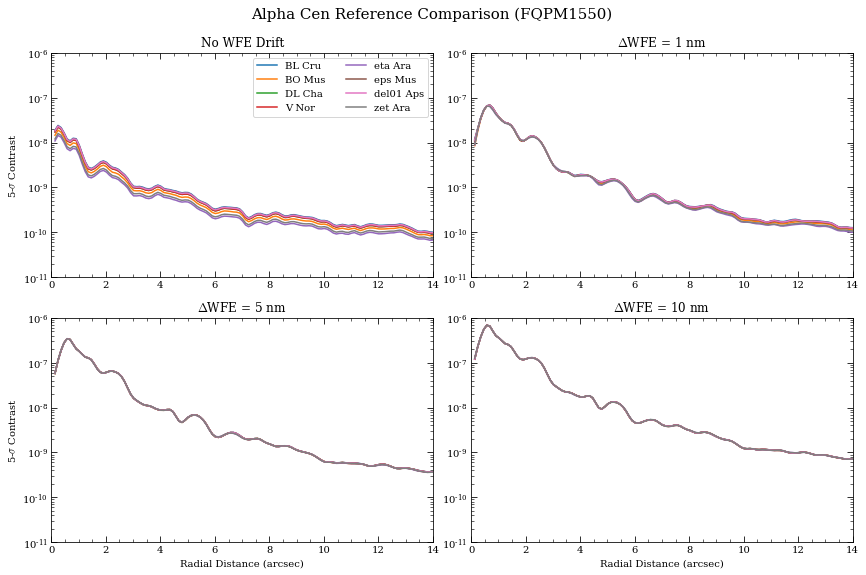

In [88]:
fig, axes = plt.subplots(2,2, figsize=(12,8))
axes = axes.flatten()
keys = list(cont_dict.keys())

for k in keys:
    rr, contrast = cont0_dict[k]
    axes[0].semilogy(rr, contrast, label=k)
    rr, contrast = cont1_dict[k]
    axes[1].semilogy(rr, contrast, label=k)
    rr, contrast = cont5_dict[k]
    axes[2].semilogy(rr, contrast, label=k)
    rr, contrast = cont10_dict[k]
    axes[3].semilogy(rr, contrast, label=k)
    
axes[0].legend(ncol=2)
fig.tight_layout()

axes[0].set_title('No WFE Drift')
axes[1].set_title('$\Delta$WFE = 1 nm')
axes[2].set_title('$\Delta$WFE = 5 nm')
axes[3].set_title('$\Delta$WFE = 10 nm')

for ax in axes:
    ax.set_ylim([1e-11,1e-6])
    ax.set_xlim([0,14])

for ax in [axes[0], axes[2]]:
    ax.set_ylabel('{}-$\sigma$ Contrast'.format(nsig))

for ax in [axes[2], axes[3]]:
    ax.set_xlabel('Radial Distance (arcsec)')
    
imask = inst.image_mask
fig.suptitle('Alpha Cen Reference Comparison ({})'.format(imask), fontsize=15)
fig.subplots_adjust(wspace=0.1, hspace=0.18, top=0.9, bottom=0.05, left=0.06)

fig.savefig('alph_cen_ref_{}.pdf'.format(imask))

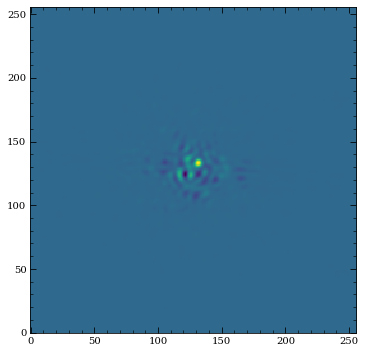

In [89]:
plt.imshow(data)